In [1]:
from openai import OpenAI
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import re
import httpx
from typing import Dict, Any, Optional, List, Tuple
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import random
import json
import glob
import getpass
from httpx import ReadTimeout
from httpcore import RemoteProtocolError as CoreRemoteProtocolError

from bikebench.benchmarking.public_benchmarking_utils import Benchmarker, ScoreReportDashboard

import llm_utils

/home/mileva/mambaforge/envs/bike-bench-cuda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


To run the OpenAI API calls you'll have to enter an API key. Uncomment the below:

In [2]:
# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass.getpass("OpenAI API key: ")

### Conditional

Precompute the necessary information for the conditional prompts:

In [3]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os, time, random

device = "cpu"
bench = Benchmarker(device=device, masked_constraints=False, gradient_free=True)

# 1) Precompute test-condition subsets (before any condition text)
train_cache = llm_utils.precompute_train_condition_pairs(
    bench,
    device=device,
    n_pairs=25,       # equals valid_n == invalid_n in the prompt
    batch_size=64,
    max_batches=50,
)


Uncomment below to regenerate the LLM responses. To evaluate the already-existing responses, this can remain commented. All evaluator calls to the benchmarker are done in the above cell, so benchmarking results will not be affected (evalution count will be accurate etc.). 

In [4]:
# os.makedirs("LLM_outputs/conditional/raw", exist_ok=True)

# def run_idx(i: int):
#     # tiny jitter helps avoid thundering herd
#     time.sleep(random.uniform(0.0, 0.15))
#     raw_train = llm_utils.run_single_condition(
#         bench=bench,
#         mode="paired",               # <-- NEW
#         train_cache=train_cache,     # <-- train cache instead of test cache
#         condition_idx=i,             # <-- text condition index
#         static_dir="LLM_prompts",
#         model="gpt-5",
#         reasoning_effort="high",
#         n_out=100,
#         save_txt_path=f"LLM_outputs/conditional/raw/{i}.txt",
#     )
#     return i, raw_train

# # 2) Threaded generation
# indices = list(range(100))
# max_workers = 20

# with ThreadPoolExecutor(max_workers=max_workers) as ex:
#     futures = [ex.submit(run_idx, i) for i in indices]
#     for fut in as_completed(futures):
#         i, _ = fut.result()
#         print(f"done {i}")

Process the raw text outputs into csvs:

In [5]:
summary = llm_utils.process_raw_folder_lenient(
    raw_dir="LLM_outputs/conditional/raw",
    processed_dir="LLM_outputs/conditional/processed",
    report_dir="LLM_outputs/conditional/reports",
    out_n=100,          # expected index range, used for filtering/sorting
    feature_cols=64,
)

print(summary[["parsed","valid","rows_in","rows_kept","bad_len_rows","dropped_bad_index","duplicate_indices_dropped","output_path"]])


                                    parsed  valid  rows_in  rows_kept  \
source                                                                  
LLM_outputs/conditional/raw/0.txt     True   True      101        100   
LLM_outputs/conditional/raw/1.txt     True   True      101        100   
LLM_outputs/conditional/raw/10.txt    True   True      101        100   
LLM_outputs/conditional/raw/11.txt    True   True      101        100   
LLM_outputs/conditional/raw/12.txt    True   True      101        100   
...                                    ...    ...      ...        ...   
LLM_outputs/conditional/raw/95.txt    True   True      101        100   
LLM_outputs/conditional/raw/96.txt    True   True      101         80   
LLM_outputs/conditional/raw/97.txt    True   True      101        100   
LLM_outputs/conditional/raw/98.txt    True   True      101        100   
LLM_outputs/conditional/raw/99.txt    True   True      101        100   

                                    bad_len_rows  

Build into one dataframe, then evaluate. 

In [6]:
all_dfs = []
for i in range(100):
    #if the file exists
    if os.path.exists(f"LLM_outputs/conditional/processed/{i}.csv"):
        df = pd.read_csv(f"LLM_outputs/conditional/processed/{i}.csv", header=None)
        if df.shape[0] < 100:
            n_repeat = (100 + df.shape[0] - 1) // df.shape[0]
            df = pd.concat([df] * n_repeat, axis=0, ignore_index=True).iloc[:100].reset_index(drop=True)
        else:
            df = df.iloc[:100].reset_index(drop=True)
    else: #sample randomly from dataset
        df = bench.data_categorical.sample(n=100, replace=True)
        df.columns = [i+1 for i in range(df.shape[1])]
    all_dfs.append(df)
all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
all_dfs.columns = bench.data_categorical.columns
generated_tens = torch.tensor(bench.convert_df_to_continuous(all_dfs).values, dtype=torch.float32)
main_scores, detailed_scores, all_evaluation_scores = bench.score(generated_tens)
bench.save_results("results/benchmark_results/gpt5_conditional")
print(main_scores)

⚠️ Warning: Column 'Down tube type' has unknown values: {'3'}
⚠️ Warning: Column 'Seat tube type' has unknown values: {'3'}


100%|██████████| 100/100 [00:08<00:00, 11.91it/s]

Design Quality ↑ (HV)      0.004908
Constraint Violation ↓       1.2877
Sim. to Data ↓ (MMD)       0.631263
Novelty ↑                 13.898317
Binary Validity ↑            0.3413
Diversity ↓ (DPP)         14.695558
Evaluation Count            75900.0
Conditional?                   True
Masked Constraints?           False
gradient_free?                 True
dtype: object


### Unconditional

Now lets try the unconditional case. In the unconditional case, we are showing actual evaluation scores on the test set conditions so that it can see examples on the exact test case it is generating for. Once again, we will precompute what we need. However, this will be calling the test set conditions, which will flag this as unconditional generation in the benchmarker. 

In [7]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os, time, random

device = "cpu"
bench = Benchmarker(device=device, masked_constraints=False, gradient_free=True)

# 1) Precompute test-condition subsets (before any condition text)
cache = llm_utils.precompute_all_conditions(
    bench,
    device=device,
    n_valid=25,
    n_invalid=25,
)


Evaluation function called after receiving test conditions; logging as unconditional evaluation!


Same thing - uncomment below to call the LLM and regenerate solutions

In [8]:
# os.makedirs("LLM_outputs/raw/unconditional", exist_ok=True)

# def run_idx(i: int):
#     # tiny jitter helps avoid thundering herd
#     time.sleep(random.uniform(0.0, 0.15))
#     raw = llm_utils.run_single_condition(
#         bench=bench,
#         mode="single",                 # <-- NEW
#         cache=cache,                   # <-- same as before
#         condition_idx=i,               # <-- same as before
#         static_dir="LLM_prompts",
#         model="gpt-5",
#         reasoning_effort="high",
#         n_out=100,
#         save_txt_path=f"LLM_outputs/unconditional/raw/{i}.txt",
#         # timeout_s=600.0,             # optional override
#     )
#     return i, raw

# # 2) Threaded generation
# indices = list(range(100))
# max_workers = 20

# with ThreadPoolExecutor(max_workers=max_workers) as ex:
#     futures = [ex.submit(run_idx, i) for i in indices]
#     for fut in as_completed(futures):
#         i, _ = fut.result()
#         print(f"done {i}")

Process results to csvs:

In [9]:
summary = llm_utils.process_raw_folder_lenient(
    raw_dir="LLM_outputs/unconditional/raw",
    processed_dir="LLM_outputs/unconditional/processed",
    report_dir="LLM_outputs/unconditional/reports",
    out_n=100,          # expected index range, used for filtering/sorting
    feature_cols=64,
)

print(summary[["parsed","valid","rows_in","rows_kept","bad_len_rows","dropped_bad_index","duplicate_indices_dropped","output_path"]])


                                      parsed  valid  rows_in  rows_kept  \
source                                                                    
LLM_outputs/unconditional/raw/0.txt     True   True      101        100   
LLM_outputs/unconditional/raw/1.txt     True   True      101        100   
LLM_outputs/unconditional/raw/10.txt    True   True      101        100   
LLM_outputs/unconditional/raw/11.txt    True   True      101        100   
LLM_outputs/unconditional/raw/12.txt    True   True      101        100   
...                                      ...    ...      ...        ...   
LLM_outputs/unconditional/raw/95.txt    True   True      101        100   
LLM_outputs/unconditional/raw/96.txt    True   True      101        100   
LLM_outputs/unconditional/raw/97.txt    True   True      101        100   
LLM_outputs/unconditional/raw/98.txt    True   True      101        100   
LLM_outputs/unconditional/raw/99.txt    True   True      101        100   

                        

Expectedly, the performance is quite a bit higher. 

In [ ]:
all_dfs = []
for i in range(100):
    #if the file exists
    if os.path.exists(f"LLM_outputs/unconditional/processed/{i}.csv"):
        df = pd.read_csv(f"LLM_outputs/unconditional/processed/{i}.csv", header=None)
        if df.shape[0] < 100:
            n_repeat = (100 + df.shape[0] - 1) // df.shape[0]
            df = pd.concat([df] * n_repeat, axis=0, ignore_index=True).iloc[:100].reset_index(drop=True)
        else:
            df = df.iloc[:100].reset_index(drop=True)
    else: #sample randomly from dataset
        df = bench.data_categorical.sample(n=100, replace=True)
        df.columns = [i+1 for i in range(df.shape[1])]
    all_dfs.append(df)
all_dfs = pd.concat(all_dfs, axis=0, ignore_index=True)
all_dfs.columns = bench.data_categorical.columns
generated_tens = torch.tensor(bench.convert_df_to_continuous(all_dfs).values, dtype=torch.float32)
main_scores, detailed_scores, all_evaluation_scores = bench.score(generated_tens)
bench.save_results("results/benchmark_results/gpt5")
print(main_scores)

⚠️ Warning: Column 'Seat tube type' has unknown values: {'3'}


100%|██████████| 100/100 [00:08<00:00, 11.76it/s]


Design Quality ↑ (HV)      0.008572
Constraint Violation ↓       0.4477
Sim. to Data ↓ (MMD)       0.363032
Novelty ↑                 10.108819
Binary Validity ↑            0.6998
Diversity ↓ (DPP)         14.076287
Evaluation Count           303600.0
Conditional?                  False
Masked Constraints?           False
gradient_free?                 True
dtype: object


Finally, lets compare some scorecards:

/home/mileva/Documents/Lyle/Bike-Bench-Internal/src/bikebench/benchmarking/public_benchmarking_utils.py:383: UserWarning: No model_colors provided; using Matplotlib cycle.
  warnings.warn("No model_colors provided; using Matplotlib cycle.")


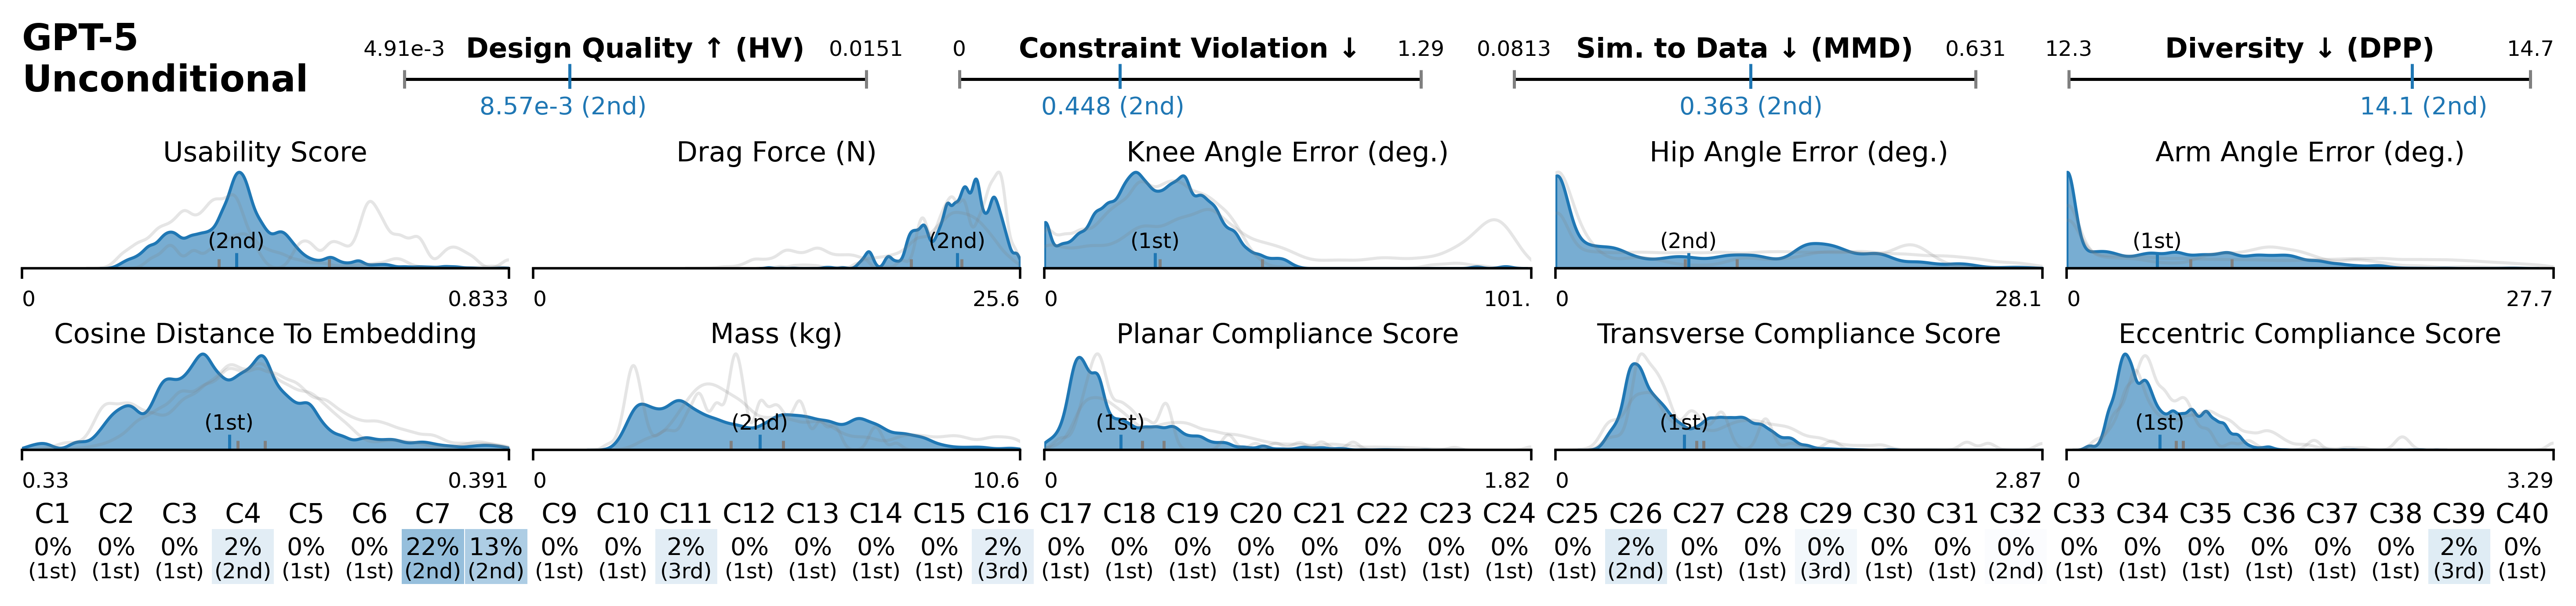

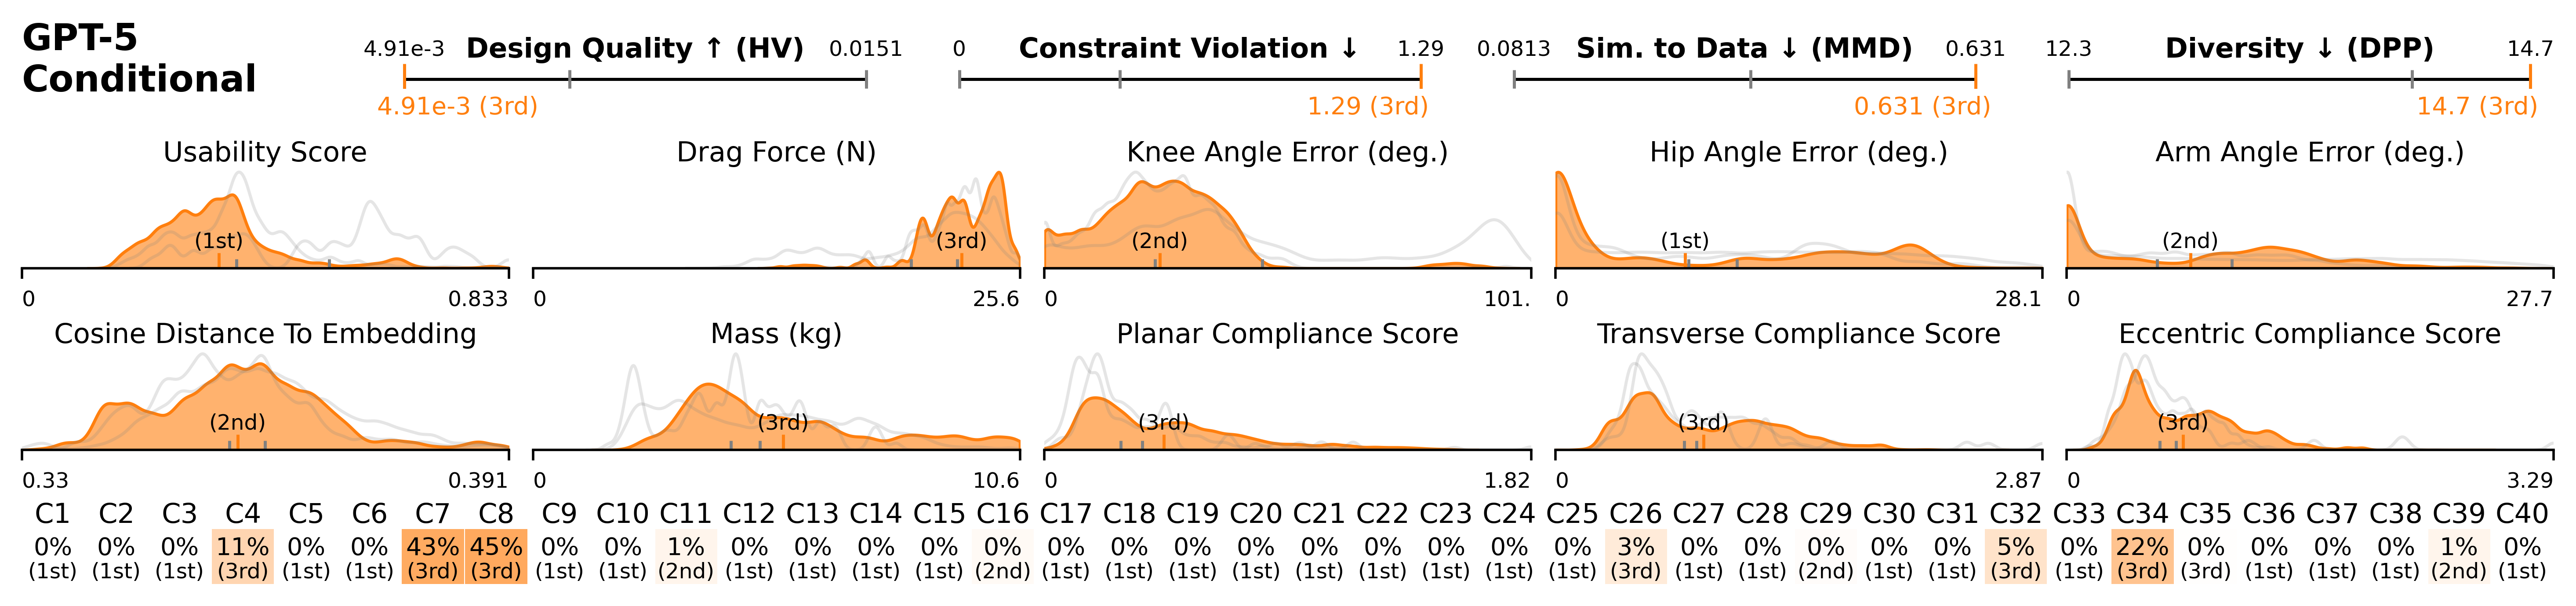

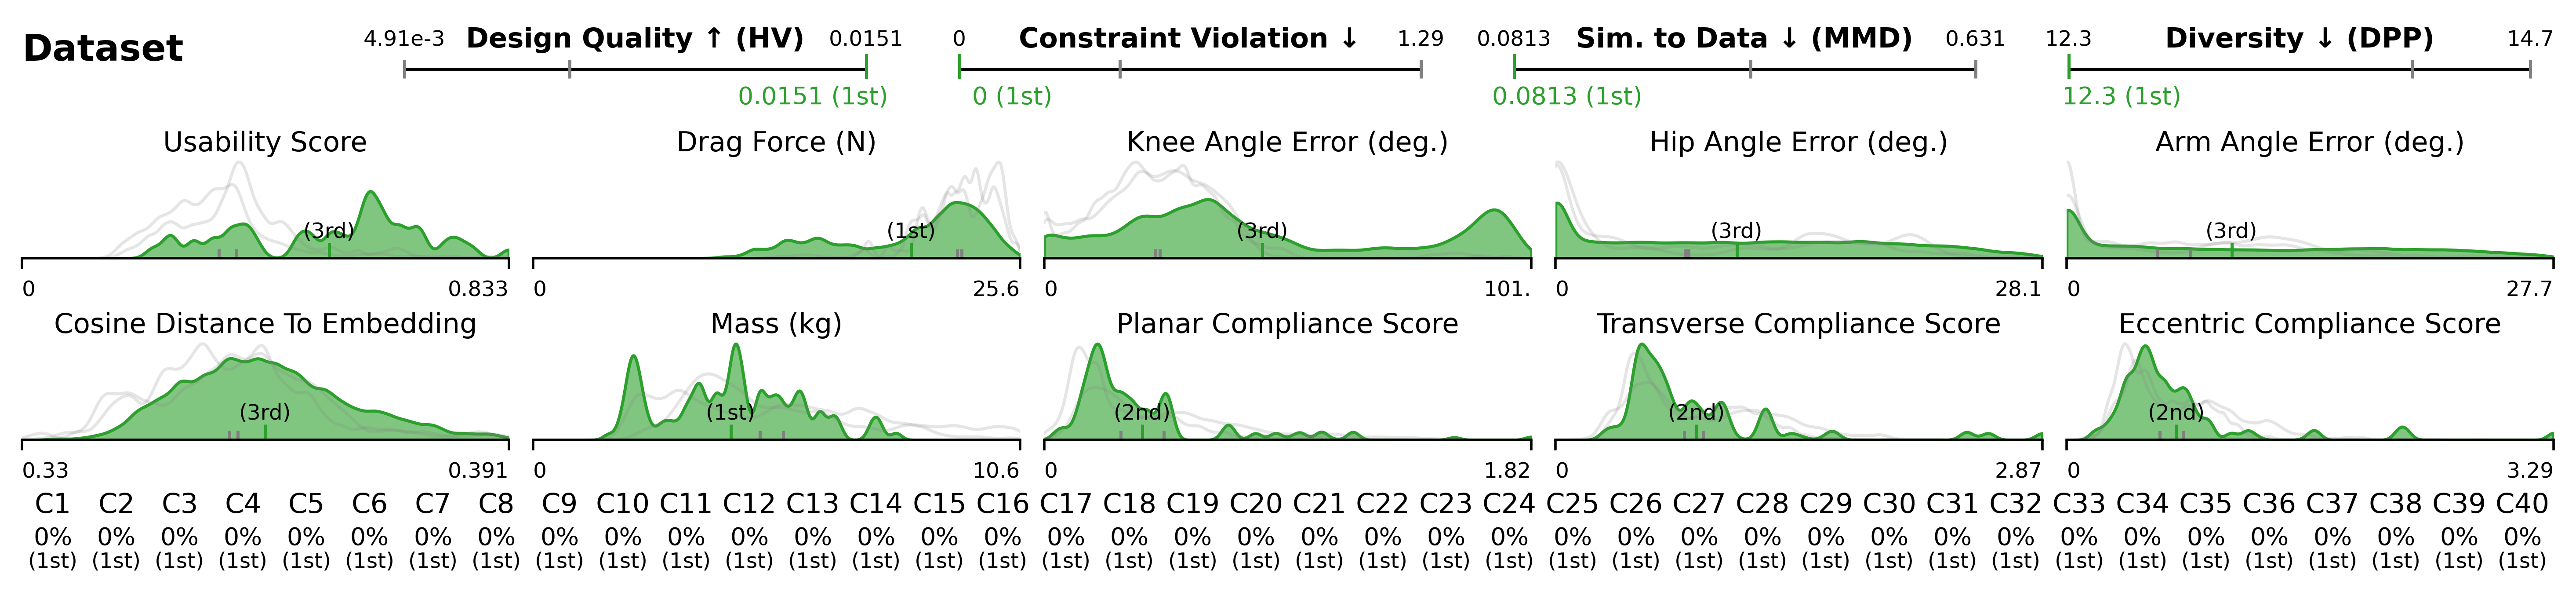

In [ ]:
filepaths_conditional = {
    "GPT-5 Unconditional": "results/benchmark_results/gpt5",
    "GPT-5 Conditional": "results/benchmark_results/gpt5_conditional",
    "Dataset": "results/benchmark_results/baseline_dataset_conditional",
}
dashboard_conditional = ScoreReportDashboard(
    filepaths = filepaths_conditional,
)
for m in filepaths_conditional.keys():
    dashboard_conditional.show_model(m)